<a href="https://colab.research.google.com/github/gschloesser/MRI_cycGAN/blob/main/Cycle_GAN_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-oj27emkd
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-oj27emkd
  Created wheel for tensorflow-examples: filename=tensorflow_examples-2a49e4e34d6fbfe2ce1451797026856edfda02fa_-cp37-none-any.whl size=265842 sha256=5bbf8226a6b9ac1d518d19c305ebd6f4074b33490dc5dbad0f3d96ccb3bbf6a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-u8law19i/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [3]:
import tensorflow as tf
import numpy as np
import nibabel as nib
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
import os
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from google.colab import drive
#drive.mount('/content/drive')

In [4]:
example_filename = '/content/drive/My Drive/GAN_IM/CT_Pair/002_Ax_T1_BRAVO_Stealth_CT.nii.gz'
example_filename1 = '/content/drive/My Drive/GAN_IM/MR_Pair/002_Ax_T1_BRAVO_Stealth.nii.gz'
path1 = '/content/drive/My Drive/GAN_IM/MR_Pair'
path2 = '/content/drive/My Drive/GAN_IM/CT_Pair'
cp_path = '/content/drive/MyDrive/GAN_IM/checkpoints'

AUTOTUNE = tf.data.AUTOTUNE
OUTPUT_CHANNELS = 3
BUFFER_SIZE = 250
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512
LAMBDA = 10
EPOCHS = 5
DEPTH = 232

In [7]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH])
    return cropped_image

def normalize_MRI(image):
    image = tf.cast(image, tf.float32)
    image = (image / (tf.math.reduce_max(image))*2) - 1
    #image = tf.image.resize(image,[256,256])
    return image

def normalize_CT(image):
    image = tf.cast(image, tf.float32)
    image = image + abs(tf.math.reduce_min(image))
    image = (image / (tf.math.reduce_max(image))*2) - 1
    #image = tf.image.resize(image,[256,256])
    return image

def preprocess_MRI(image):
    #image = random_jitter(image)
    image = normalize_MRI(image)
    return image
def preprocess_CT(image):
    #image = random_jitter(image)
    image = normalize_CT(image)
    return image

def pipe_MRI_train(path):
    j = 0
    for filename in os.listdir(path):
      img = nib.load(path + '/' + filename)
      arr = img.get_fdata()
      sz = np.shape(arr)
      print(sz)
      arr1 = np.zeros((sz[2],sz[0],sz[1],3))
      for i in range(DEPTH-2):
          arr1[i,:,:,0] = preprocess_MRI(arr[:,:,i])
          arr1[i,:,:,1] = preprocess_MRI(arr[:,:,i+1])
          arr1[i,:,:,2] = preprocess_MRI(arr[:,:,i+2]) 
      if j == 0:
          arr2 = arr1
      else:
          np.append(arr2,arr1)
      j = j + 1
      print(np.shape(arr2))
    train_data = tf.data.Dataset.from_tensor_slices(arr2)
    data = train_data.map(do_nothing, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return data

def pipe_CT_train(path):
    j = 0
    for filename in os.listdir(path):
      img = nib.load(path + '/' + filename)
      arr = img.get_fdata()
      sz = np.shape(arr)
      print(sz)
      arr1 = np.zeros((sz[2],sz[0],sz[1],3))
      for i in range(DEPTH-2):
          arr1[i,:,:,0] = preprocess_CT(arr[:,:,i])
          arr1[i,:,:,1] = preprocess_CT(arr[:,:,i+1])
          arr1[i,:,:,2] = preprocess_CT(arr[:,:,i+2]) 
      if j == 0:
          arr2 = arr1
      else:
          np.append(arr2,arr1)
      j = j + 1
      print(np.shape(arr2))
    train_data = tf.data.Dataset.from_tensor_slices(arr2)
    data = train_data.map(do_nothing, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return data

def pipe_MRI_test(filename):
    img = nib.load(filename)
    arr = img.get_fdata()
    sz = np.shape(arr)
    arr1 = np.zeros((sz[2],sz[0],sz[1],3))
    for i in range(DEPTH-2):
        arr1[i,:,:,0] = preprocess_CT(arr[:,:,i])
        arr1[i,:,:,1] = preprocess_CT(arr[:,:,i+1])
        arr1[i,:,:,2] = preprocess_CT(arr[:,:,i+2])
    train_data = tf.data.Dataset.from_tensor_slices(arr1)
    data = train_data.cache().map(do_nothing, num_parallel_calls=AUTOTUNE).cache().batch(BATCH_SIZE)
    return data

def pipe_CT_test(filename):
    img = nib.load(filename)
    arr = img.get_fdata()
    sz = np.shape(arr)
    arr1 = np.zeros((sz[2],sz[0],sz[1],3))
    for i in range(DEPTH-2):
        arr1[i,:,:,0] = preprocess_MRI(arr[:,:,i])
        arr1[i,:,:,1] = preprocess_MRI(arr[:,:,i+1])
        arr1[i,:,:,2] = preprocess_MRI(arr[:,:,i+2])     
    train_data = tf.data.Dataset.from_tensor_slices(arr1)
    data = train_data.cache().map(do_nothing, num_parallel_calls=AUTOTUNE).cache().batch(BATCH_SIZE)
    return data
  
def do_nothing(image):
    return tf.cast(image, tf.float32)

In [8]:
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

train_MRI = pipe_MRI_train(path1)
train_CT = pipe_CT_train(path2)

samp_MRI = next(iter(train_MRI))
samp_CT = next(iter(train_CT))

(512, 512, 232)
(512, 512, 232)
(512, 512, 232)
(512, 512, 232)
(512, 512, 232)
(512, 512, 232)
(512, 512, 232)
(512, 512, 232)
(512, 512, 232)
(512, 512, 232)
(512, 512, 232)
(512, 512, 232)


In [9]:
print(type(train_MRI))
print(train_MRI)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
<BatchDataset shapes: (None, 512, 512, 3), types: tf.float32>


In [10]:
print(type(samp_MRI))
print(samp_MRI)
print(samp_MRI.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[[[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  [[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  [[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  ...

  [[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  [[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  [[-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]]], shape=(1, 512, 512, 3), dtype=float32)
(1, 512, 512, 3)


(512, 512)


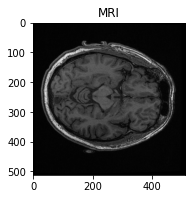

In [11]:
plt.subplot(121)
plt.title('MRI')
print(samp_MRI[0][:,:,0].shape)
plt.imshow((samp_MRI[0][:,:,0] + 1.0) * 0.5,cmap='gray')

In [12]:
ex_MRI = samp_MRI[0][:,:,0]
print(ex_MRI.shape)
ex_MRI = np.asarray(ex_MRI)
print(np.median(ex_MRI))

(512, 512)
-0.9449118


(512, 512)


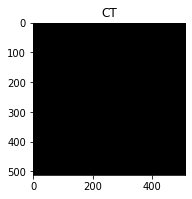

In [13]:
plt.subplot(121)
plt.title('CT')
print(samp_CT[0][:,:,0].shape)
plt.imshow((samp_CT[0][:,:,1] + 1.0) * 0.5,cmap='gray')


In [14]:
ex_CT = samp_CT[0][:,:,0]
print(ex_CT.shape)
ex_CT = np.asarray(ex_CT)
print(np.median(ex_CT))

(512, 512)
0.0


In [15]:
to_CT = generator_g(samp_MRI)
to_MRI = generator_f(samp_CT)

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)


def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [17]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


checkpoint_path = cp_path

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [18]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0][:,:,0], prediction[0][:,:,0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5, cmap = 'gray')
    plt.axis('off')
    plt.show()


In [19]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


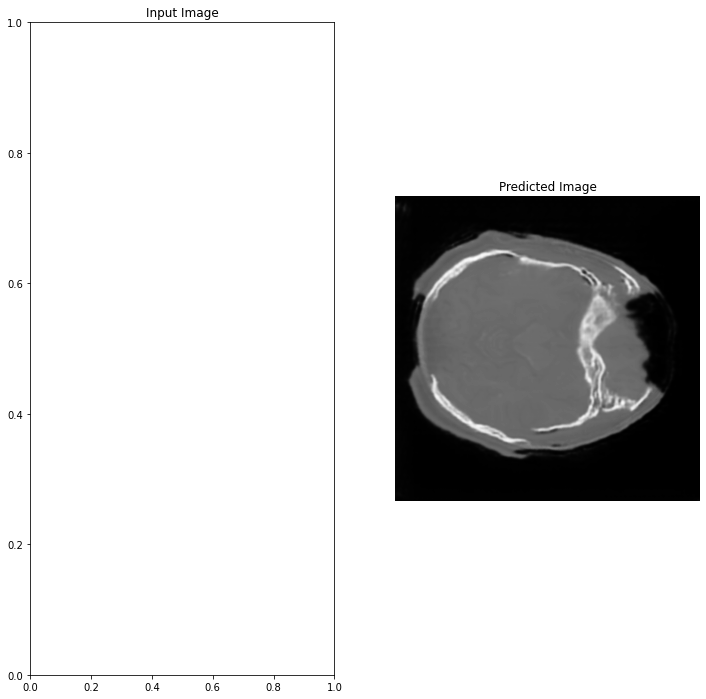

Saving checkpoint for epoch 100 at ./checkpoints/train/ckpt-20
Time taken for epoch 100 is 100.77895951271057 sec



In [20]:
EPOCHS = 100
for epoch in range(EPOCHS):
    start = time.time()
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_MRI, train_CT)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g, samp_MRI)

    
    if (epoch + 1) % 5 == 0:
      ckpt_save_path = ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                          ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

In [22]:
def gen_im(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]] 
  title = ['Input Image', 'Predicted Image']
 
  for i in range(2):
    print(display_list[0].shape)
    print(display_list[1].shape)
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow((display_list[i][:,:,0] + 1.0) * 0.5,cmap = 'gray')
    plt.axis('off')
  plt.show()
  return display_list[1]

In [23]:
test_MRI = pipe_MRI_test(example_filename1)
test_CT = pipe_CT_test(example_filename)

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


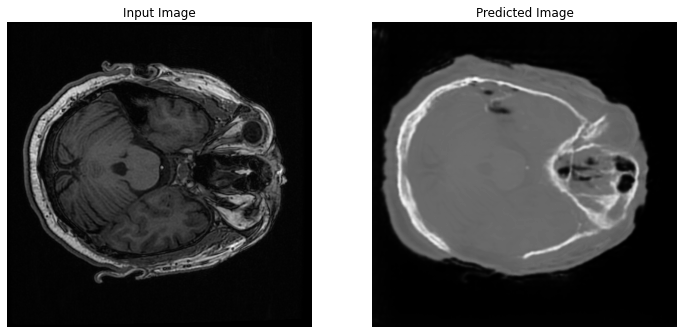

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


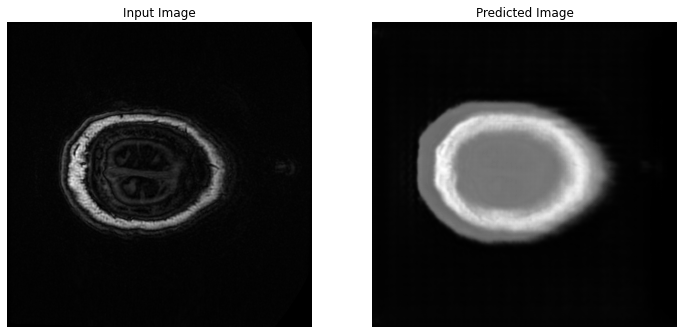

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


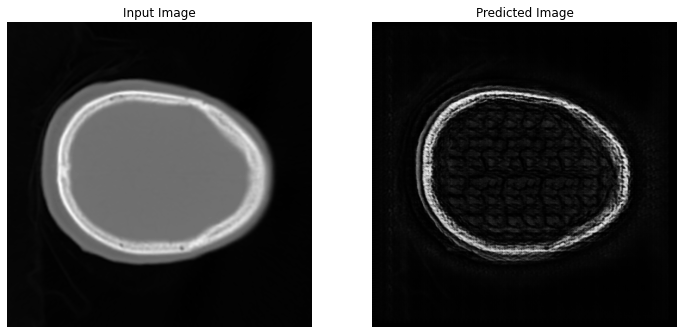

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


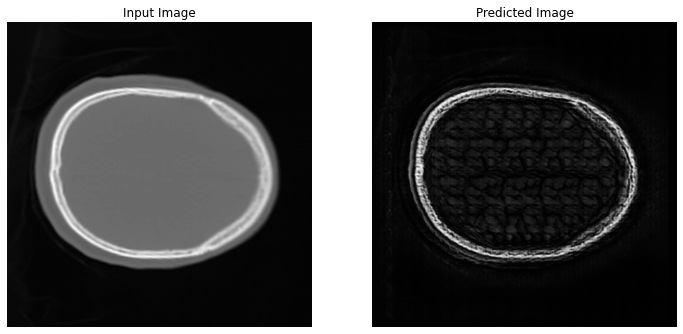

In [24]:
for inp in train_MRI.take(2):
  pred = gen_im(generator_g, inp)


for inp in train_CT.take(2):
  pred = gen_im(generator_f, inp)

#PRED = pred
#print(PRED)

In [ ]:
for inp in train_MRI.take(5):
  pred = gen_im(generator_g, inp)


#PRED = pred
#print(PRED)